In [1]:
import sys
sys.path.append("..")

In [2]:
import subprocess
from random import random, randint
from nfa_lib import NFA, random_matrix_for_nfa, count_nfa
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
from tqdm.auto import tqdm as tqdm
import pandas as pd
import pickle
import numpy as np
from multiprocessing import Pool, TimeoutError
sns.set(rc={"figure.figsize": (14,10),
            'legend.fontsize': 'x-large',
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'})

In [17]:
def random_run():
    n_states = randint(100, 200)
    sparsity = round(0.01 * random() + 0.99, 5)
    n_initial = randint(1, min(n_states, 2))
    n_final = randint(1, min(n_states, 3))
    # string_length = randint(3, 10)
    string_length = 25
    rand_matrix = random_matrix_for_nfa(n_states=n_states, sparsity=sparsity, n_initial=n_initial, n_final=n_final)
    rand_nfa = NFA.from_random_matrix(rand_matrix)
    rand_nfa_text = rand_nfa.to_text()
    
    res_array = []
    
    # epsilon = round(random() * 45 + 50, 1) # epsilon \in [5, 100]
    epsilon = 250000000
    kappa_multiple = 1
    # phi_multiple = round(2 ** (7 + random() * 5)) # phi_multiple \in [32, 1024]
    phi_multiple = 500

    cpp_input = f"{string_length} {epsilon} {kappa_multiple} {phi_multiple}\n" + rand_nfa_text
    program = ["timeout", "300", "../cpp/main", "0"]
    result = subprocess.run(program, 
                            stdout=subprocess.PIPE, 
                            input=cpp_input,
                            encoding="utf-8")
    res_dict = {}
    if result.returncode == 0:
        invalid = False
        for line in result.stdout.split("\n"):
            if "Got 0 when" in line or "Empty NFA" in line:
                invalid = True
                break
            l_split = line.split()
            if len(l_split) == 2:
                k, v = l_split
                res_dict[k] = float(v) if "." in v else int(v)
        if not invalid:
            res_dict["n_states"] = len(rand_nfa.states)
            res_dict["sparsity"] = sparsity
            res_dict["str_repr"] = cpp_input
            res_dict["string_len"] = string_length
            res_dict["epsilon"] = epsilon
            res_dict["kappa_multiple"] = kappa_multiple
            res_dict["phi_multiple"] = phi_multiple
            res_array.append(res_dict)


    return res_array

In [18]:
res = random_run()
res

[{'retries_per_sample': 27438,
  'sample_size': 1,
  'sample_misses': 55,
  'sample_hits': 2685,
  'miss_ratio': 0.0204842,
  'estimation': 14195491,
  'estimation_time': 42777,
  'n_states': 166,
  'sparsity': 0.99155,
  'str_repr': '25 250000000 1 500\n166 2 494\n0 1 10 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 128 129 13 130 131 132 133 134 135 136 137 138 139 14 140 141 142 144 145 146 147 148 149 15 150 151 152 153 154 155 157 158 16 160 161 163 164 165 166 167 168 169 17 170 171 172 173 174 175 176 177 178 179 18 180 19 2 20 21 22 24 25 26 27 28 29 3 30 31 33 34 36 37 38 39 40 42 43 44 45 46 47 48 49 5 50 51 52 53 54 56 58 59 6 60 61 62 63 64 65 66 67 68 69 7 70 71 72 73 74 75 76 77 78 79 8 80 81 82 83 84 85 86 87 88 89 9 90 91 92 93 94 95 96 97 98 99\n0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
# results = []
samples = 0
errors = []
error_count = 0
n_proc = 6
with Pool(processes=n_proc) as pool:
    while error_count < 3:
        multiproc_results = [pool.apply_async(random_run) 
                             for i in range(6*n_proc)]
        for res_promise in tqdm(multiproc_results):
            res = None
            try:
                res = res_promise.get()
            except TimeoutError:
                continue

            if isinstance(res, Exception):
                errors.append(res)
                error_count += 1
                continue
            else:
                samples += 1
                if res:
                    results.extend(res)

        with open("cpp_random_big.pkl", "wb") as fd:
            pickle.dump(results, fd)
        print(f"Wrote pickle file for {len(results)} results")

In [5]:
with open("cpp_random_big.pkl", "rb") as fd:
    results = pickle.load(fd)

In [6]:
df = pd.DataFrame(results)

In [7]:
df["rel_error"] = abs(df.estimation - df.bruteforce)/df.bruteforce

<AxesSubplot:xlabel='n_states', ylabel='rel_error'>

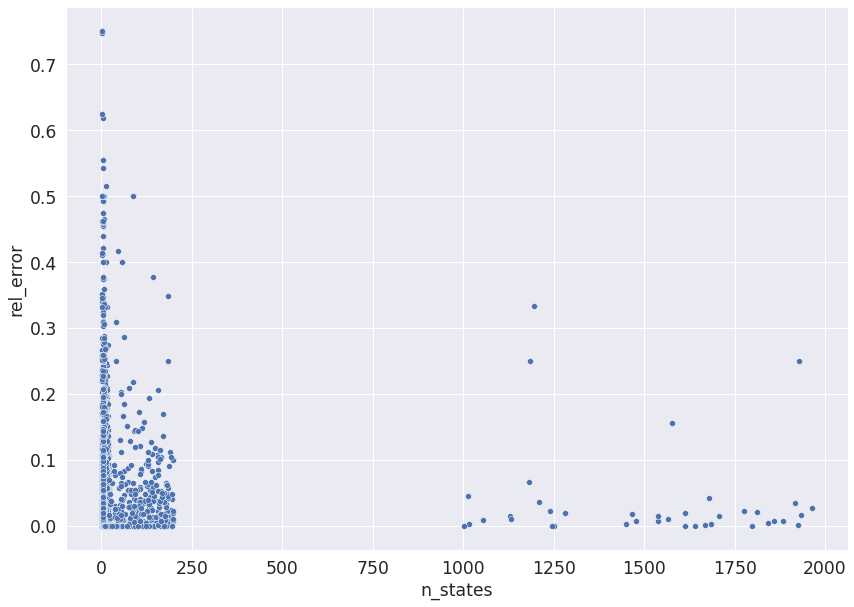

In [14]:
sns.scatterplot(data=df, x="n_states", y="rel_error")

<AxesSubplot:xlabel='n_states', ylabel='estimation_time'>

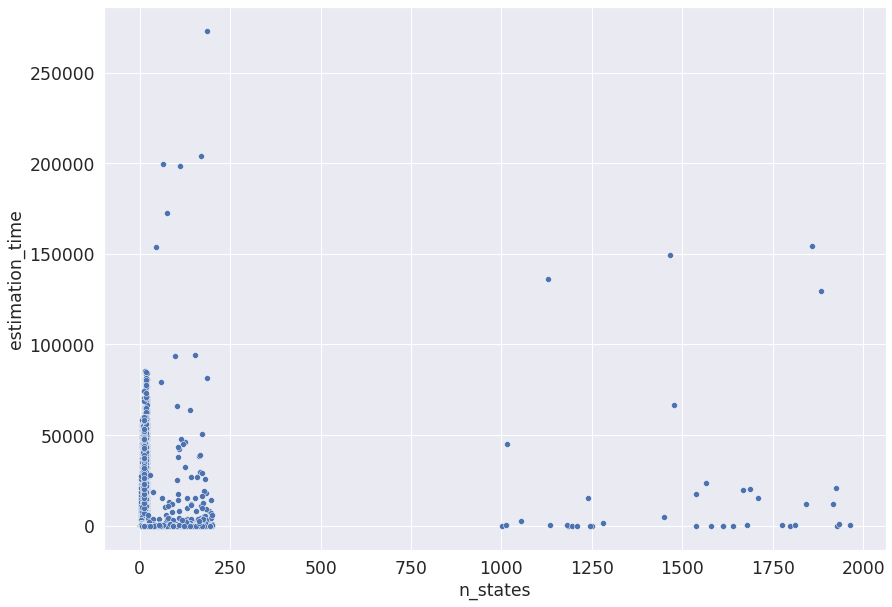

In [15]:
sns.scatterplot(data=df, x="n_states", y="estimation_time")

In [16]:
df[df.epsilon < 80].rel_error.quantile(.99)

0.20922681655262296

<IPython.core.display.Javascript object>


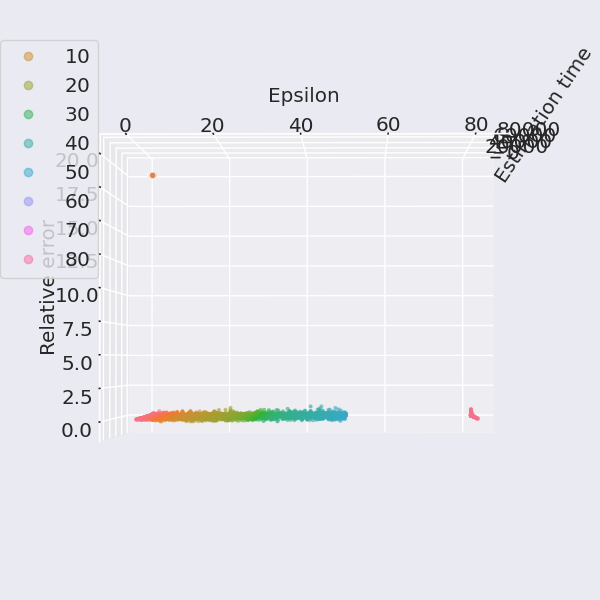

In [100]:
%matplotlib notebook
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df.estimation_time, df.epsilon, df.rel_error, s=4, c=df.epsilon,
                marker='o', cmap=cmap, alpha=0.5)
ax.set_xlabel('Estimation time')
ax.set_ylabel('Epsilon')
ax.set_zlabel('Relative error')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(0.18, 0.95), loc=0)

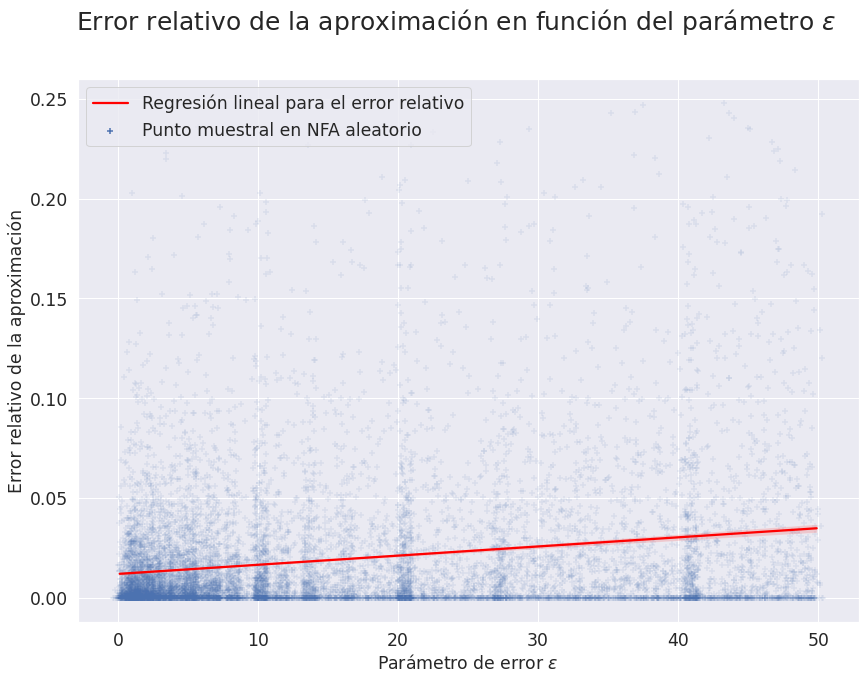

In [141]:
sns.regplot(data=df[(df.epsilon < 50) & (df.rel_error<0.25)], x="epsilon", y="rel_error", 
            scatter_kws={"alpha": 0.1}, marker="+", x_jitter=0.5,
            line_kws={"color": "red"})
plt.ylabel("Error relativo de la aproximación")
plt.xlabel("Parámetro de error $\epsilon$")
plt.suptitle("Error relativo de la aproximación en función del parámetro $\epsilon$", fontsize=25)
leg = plt.legend(["Regresión lineal para el error relativo", "Punto muestral en NFA aleatorio"])

for lh in leg.legendHandles: 
    lh.set_alpha(1)

In [193]:
df["kappa"] = df.n_states * df.string_len / (df.epsilon * df.phi_multiple)

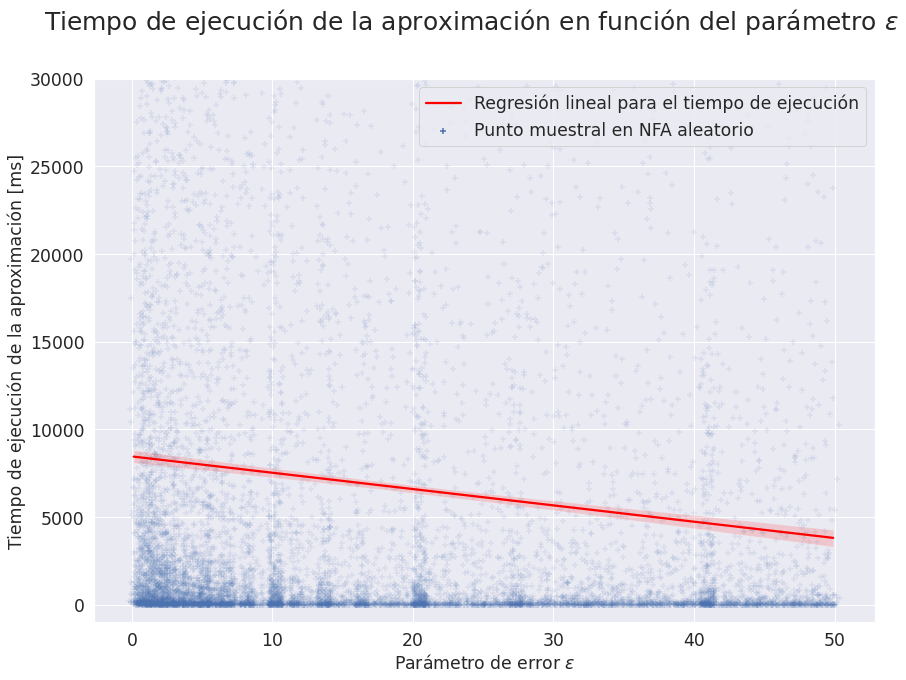

In [196]:
sns.regplot(data=df[(df.epsilon < 50) & (df.estimation_time<60000)], x="epsilon", y="estimation_time", 
            scatter_kws={"alpha": 0.1}, marker="+", x_jitter=0.5,
            line_kws={"color": "red"})
plt.ylabel("Tiempo de ejecución de la aproximación [ms]")
plt.xlabel("Parámetro de error $\epsilon$")
plt.ylim(-1000,30000)
plt.suptitle("Tiempo de ejecución de la aproximación en función del parámetro $\epsilon$", fontsize=25)
leg = plt.legend(["Regresión lineal para el tiempo de ejecución", "Punto muestral en NFA aleatorio"])

for lh in leg.legendHandles: 
    lh.set_alpha(1)

In [30]:
df[(df.rel_error > 0) & (df.epsilon < 3)].sort_values(by="rel_error", ascending=False).drop(columns=["str_repr"])

,retries_per_sample,sample_size,sample_misses,sample_hits,miss_ratio,bruteforce,bruteforce_time,estimation,estimation_time,n_states,sparsity,string_len,epsilon,kappa_multiple,phi_multiple,rel_error
9279,245709,29,0,290,0.000000,64,0,86.1260,1,2,0.56,6,2.28,1,450,0.345719
10906,420798,432,0,17280,0.000000,128,0,102.0030,322,6,0.66,7,0.73,1,350,0.203102
10916,330937,108,124,4320,0.028704,128,0,104.8930,97,6,0.66,7,2.93,1,175,0.180523
9243,254084,33,97,330,0.293939,64,0,74.9217,3,2,0.56,6,2.05,1,125,0.170652
5847,290639,58,0,1508,0.000000,16,0,13.3621,6,6,0.96,6,2.93,1,350,0.164869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10398,456815,753,0,47439,0.000000,647,15,646.9790,478,7,0.88,12,1.02,1,500,0.000032
9156,460739,800,0,88800,0.000000,488,15,488.0130,1493,11,0.89,12,1.71,1,300,0.000027
5877,494126,1339,19,137917,0.000138,7936,217,7936.1900,6045,10,0.90,13,1.02,1,250,0.000024
104,594950,6343,0,926078,0.000000,4096,175,4096.0800,59010,13,0.54,12,0.28,1,450,0.000020


In [40]:
%%time
probe = df.loc[9279]
cpp_input_nfa = probe.str_repr
cpp_input_nfa = cpp_input_nfa[cpp_input_nfa.find("\n") :]
str_len = probe.string_len
ests = []
for phi in tqdm([25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500]):
    eps = round(100/phi, 5)
    cpp_input = f'{str_len} {eps} 1 {phi}\n{cpp_input_nfa}'
    for i in range(50):
        result = subprocess.run(["timeout", "300", "./cpp/main"], 
                                    stdout=subprocess.PIPE, 
                                    input=cpp_input,
                                    encoding="utf-8")
        res_dict2 = {}
        if result.returncode == 0:
            invalid = False
            for line in result.stdout.split("\n"):
                if "Got 0 when" in line or "Empty NFA" in line:
                    print(line)
                    invalid = True
                    break
                l_split = line.split()
                if len(l_split) == 2:
                    k, v = l_split
                    res_dict2[k] = float(v) if "." in v else int(v)
            if not invalid:
                res_dict2["epsilon"] = eps
                res_dict2["phi_multiple"] = phi
                ests.append(res_dict2)

100%|███████████████████████████████████████████| 14/14 [00:11<00:00,  1.19it/s]

CPU times: user 313 ms, sys: 2.68 s, total: 2.99 s
Wall time: 11.8 s


In [8]:
df["total_samples"] = df.sample_hits + df.sample_misses

In [9]:
df["samples_times_nm"] = df.total_samples * df.sample_size * df.epsilon

<AxesSubplot:xlabel='samples_times_nm', ylabel='estimation_time'>

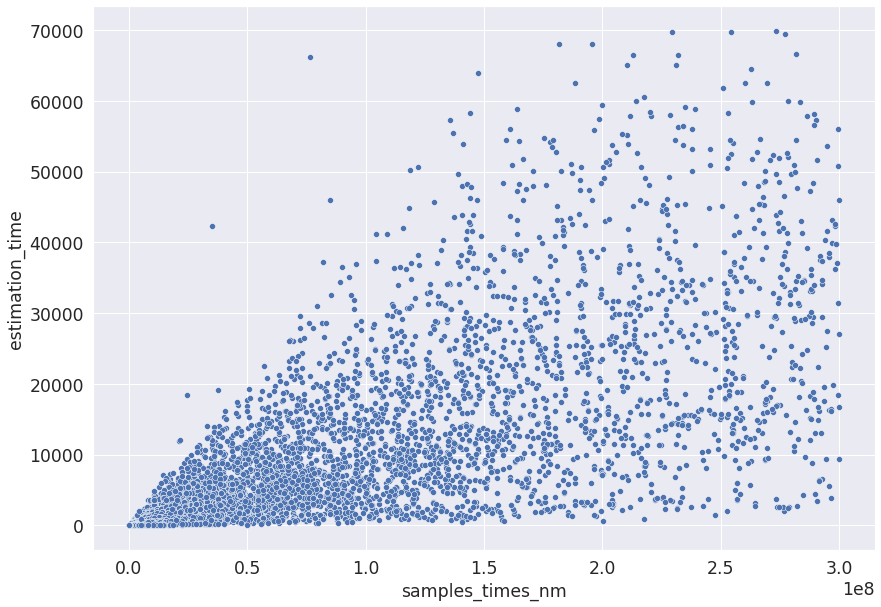

In [11]:
from matplotlib import rc
rc('text',usetex=False)
sns.scatterplot(data=df[(df.samples_times_nm < 3e8) & (df.estimation_time < 75000)], x="samples_times_nm", y="estimation_time")

In [98]:
df["real_n_states"] = df.total_samples / df.sample_size

<AxesSubplot:xlabel='linear', ylabel='estimation_time'>

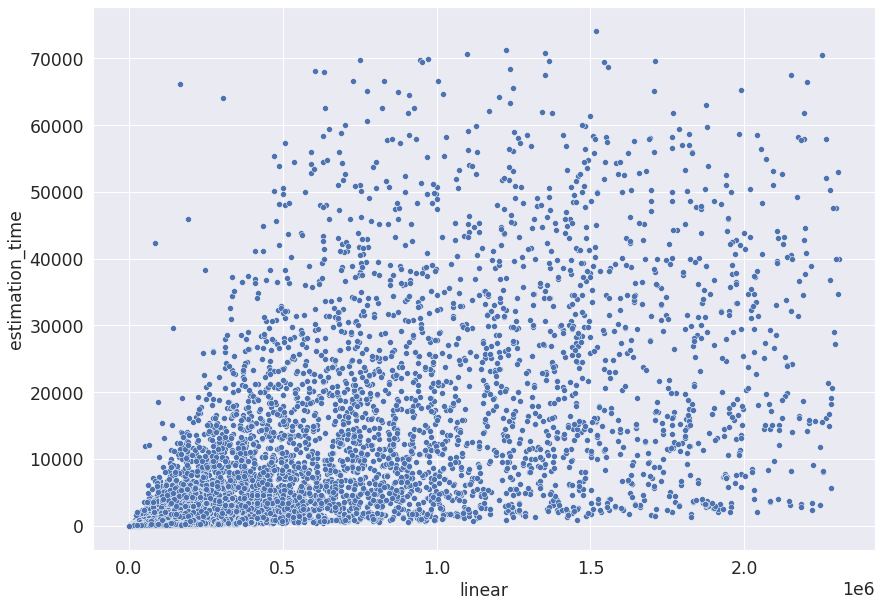

In [126]:
rc('text',usetex=False)
df["linear"] = df.total_samples * df.string_len
sns.scatterplot(data=df[(df.linear < df.linear.quantile(.95)) & (df.estimation_time < 75000)], x="linear", y="estimation_time")

<AxesSubplot:xlabel='linear', ylabel='estimation_time'>

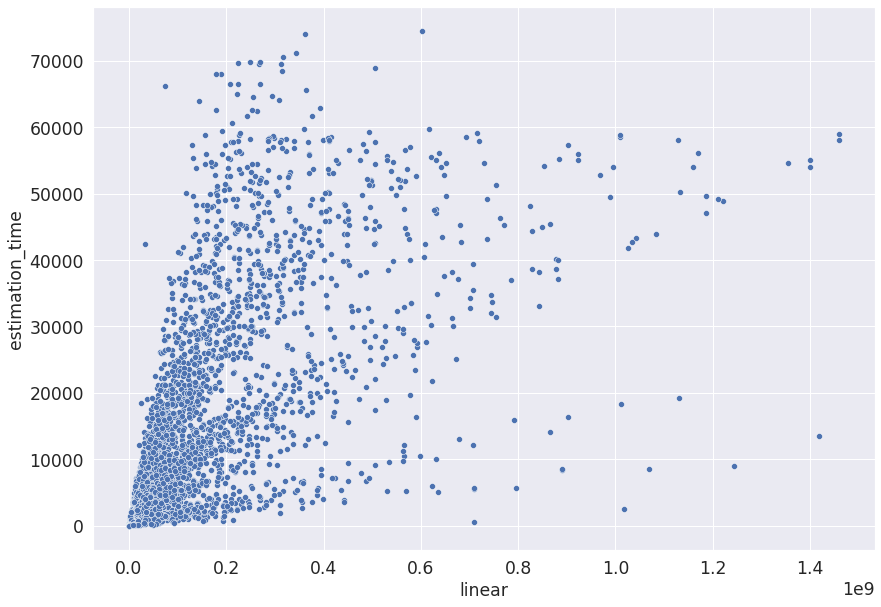

In [143]:
rc('text',usetex=False)
df["linear"] = df.real_n_states ** 3 * df.string_len ** 2 / df.epsilon
sns.scatterplot(data=df[(df.linear < df.linear.quantile(.95)) & (df.sample_size > 0.95 * df.real_n_states * df.string_len / df.epsilon) 
                        & (df.estimation_time < 75000)],
                 x="linear", y="estimation_time")

In [148]:
from matplotlib import rc
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')
plot_range = 1e9
time_constant = 2e-4
max_y = plot_range * time_constant * 1.2
X_plot = np.linspace(0, plot_range, int(plot_range / 10))
plt.plot(X_plot, X_plot * time_constant, c="r")
sns.scatterplot(data=df[(df.linear < plot_range) & (df.estimation_time < max_y)], x="linear", y="estimation_time")
plt.xlim((0, plot_range))
plt.ylim((-plot_range * 1e-4, max_y))
plt.xlabel(r"$\frac{|Q|^3 n^3}{\epsilon}$", fontsize=24)
plt.ylabel("Tiempo de estimación [ms]")
plt.title(r"Tiempo de estimación respecto a $\frac{|Q|^3 n^3}{\epsilon}$"+"\n", fontsize=34)
plt.text(x=plot_range * 1e-2, y=0.6 * max_y, 
         s="El tiempo de ejecución en ms\n está acotado por $\\textcolor{blue}{8 \\cdot 10^{-2} \\cdot \\frac{|Q|^3 n^3}{\epsilon}}$",
         fontsize=24)

Text(10000000.0, 144000.0, 'El tiempo de ejecución en ms\n está acotado por $\\textcolor{blue}{8 \\cdot 10^{-2} \\cdot \\frac{|Q|^3 n^3}{\\epsilon}}$')

In [41]:
df_probe = pd.DataFrame(ests)

In [42]:
df_probe["rel_error"] = abs(df_probe.estimation - probe.bruteforce)/probe.bruteforce

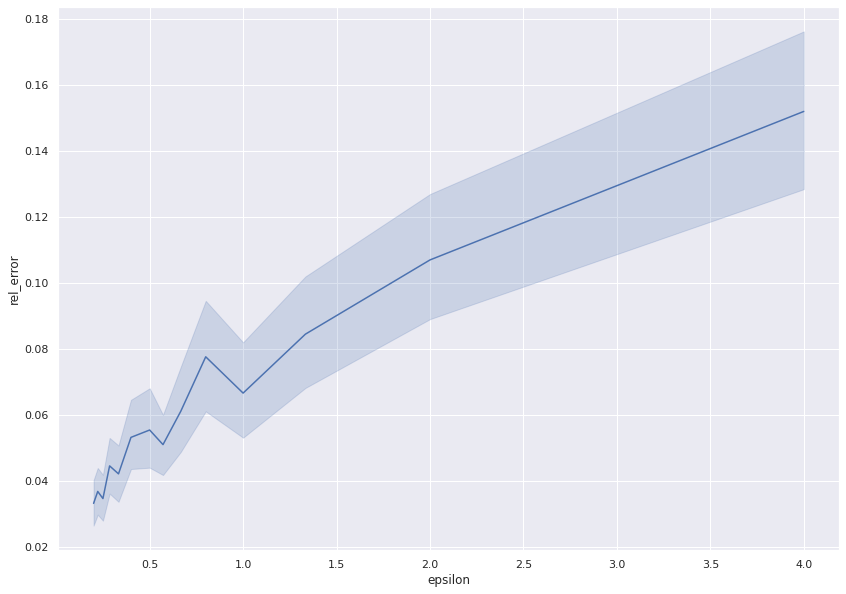

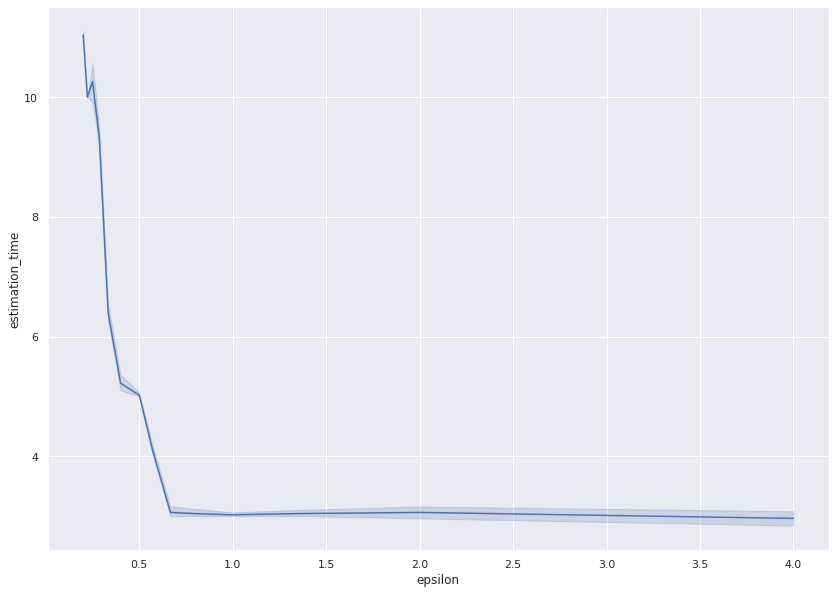

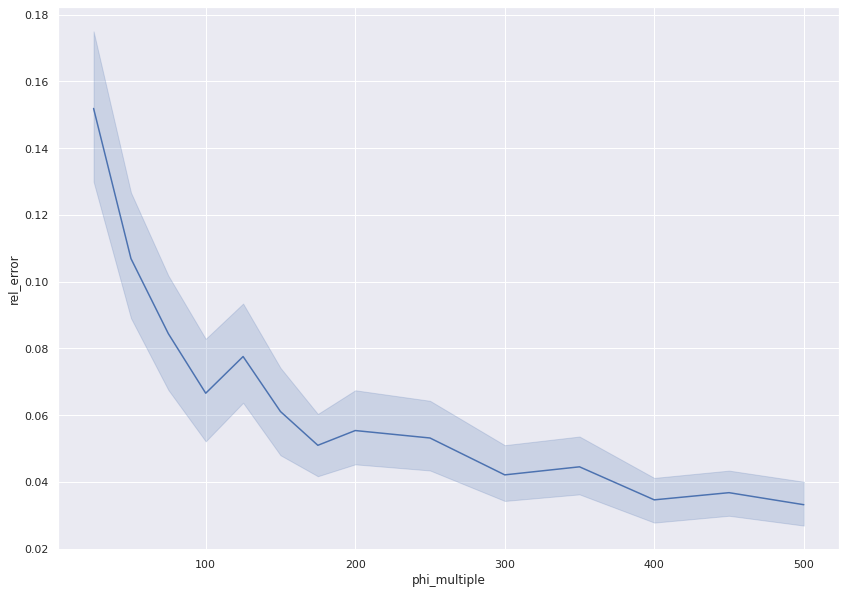

<AxesSubplot:xlabel='phi_multiple', ylabel='estimation_time'>

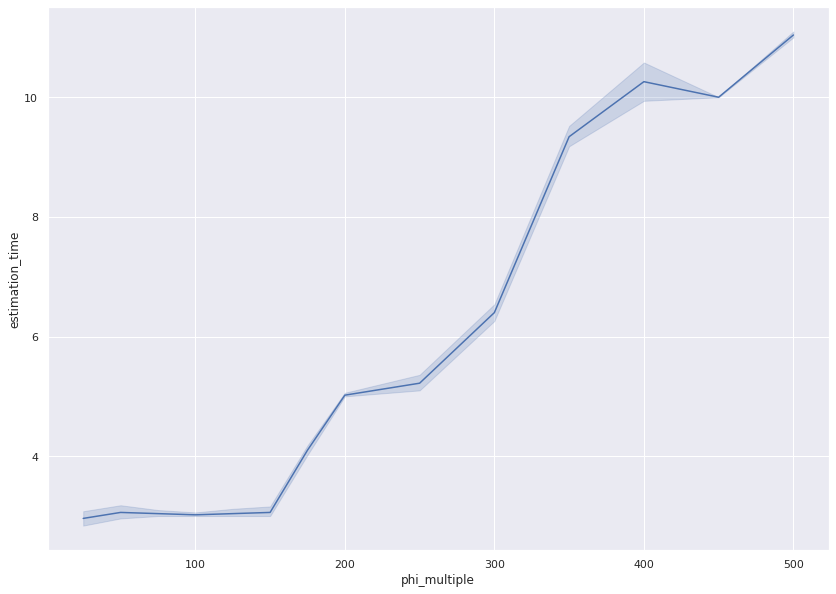

In [43]:
%matplotlib inline
sns.set(rc={"figure.figsize": (14,10)})
sns.lineplot(data=df_probe, x="epsilon", y="rel_error")
plt.show()
sns.lineplot(data=df_probe, x="epsilon", y="estimation_time")
plt.show()
sns.lineplot(data=df_probe, x="phi_multiple", y="rel_error")
plt.show()
sns.lineplot(data=df_probe, x="phi_multiple", y="estimation_time")

# Pentanacci NFA

In [86]:
rand_matrix = np.array(
   [[0, 0, 1, 0, 1, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 1, 0, 1, 0, 0],
   [0, 1, 0, 0, 1, 0],
   [0, 0, 0, 0, 0, 0],
   [1, 1, 0, 1, 0, 0],
   [1, 0, 0, 0, 1, 0],
   [1, 0, 0, 0, 0, 1],
   [0, 1, 1, 1, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 1, 0, 1, 0, 1],
   [0, 0, 1, 0, 0, 0],
   [0, 0, 0, 1, 0, 1],
   [1, 0, 0, 0, 1, 0]])

array([[0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0]])

In [78]:
data = [rand_nfa.bruteforce_count_only(i) for i in range(26)]

In [81]:
[data[i+1] / data[i] for i in range(1, 25)]

[2.0,
 3.5,
 2.142857142857143,
 1.8666666666666667,
 2.0,
 1.9821428571428572,
 1.954954954954955,
 1.9631336405529953,
 1.9671361502347418,
 1.9665871121718377,
 1.9660194174757282,
 1.9657407407407408,
 1.965928717224054,
 1.9659771583739318,
 1.9659571010724732,
 1.965946191676654,
 1.9659449232709691,
 1.9659484602224122,
 1.965948802184324,
 1.9659483110412075,
 1.9659481587913195,
 1.9659481928633655,
 1.9659482494953409,
 1.9659482458453843]

In [82]:
data

[0,
 1,
 2,
 7,
 15,
 28,
 56,
 111,
 217,
 426,
 838,
 1648,
 3240,
 6369,
 12521,
 24616,
 48394,
 95140,
 187040,
 367711,
 722901,
 1421186,
 2793978,
 5492816,
 10798592,
 21229473]

In [85]:
print(rand_nfa.to_text())

6 2 20
0 1 2 3 4 5
0 0 0 1 0 1
1 0 0 0 1 0
0 1
0 0 4
0 0 2
0 1 4
0 1 0
1 1 5
1 1 0
2 0 1
2 0 3
2 1 2
2 1 1
2 1 3
3 0 4
3 0 1
4 1 5
4 1 1
4 1 3
5 0 0
5 0 1
5 0 3
5 1 2


In [56]:
# res_array = []
for rep in range(50):
    for str_len in tqdm(range(20, 26)):
        cpp_input = f'{str_len} 0.5 1 500\n2 2 4\n0 1\n0 1\n0 1\n0 1\n0 0 1\n0 0 0\n1 0 0\n1 1 0'

        program = ["timeout", "90", "./cpp/main", "0"]
        result = subprocess.run(program, 
                                stdout=subprocess.PIPE, 
                                input=cpp_input,
                                encoding="utf-8")
        res_dict = {}
        if result.returncode == 0:
            invalid = False
            for line in result.stdout.split("\n"):
                if "Got 0 when" in line or "Empty NFA" in line:
                    invalid = True
                    break
                l_split = line.split()
                if len(l_split) == 2:
                    k, v = l_split
                    res_dict[k] = float(v) if "." in v else int(v)
            if not invalid:
                res_dict["str_len"] = str_len
                res_array.append(res_dict)

100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.04s/it]


In [11]:
res_array

[{'retries_per_sample': 188512,
  'sample_size': 12,
  'sample_misses': 0,
  'sample_hits': 24,
  'miss_ratio': 0,
  'bruteforce': 2,
  'bruteforce_time': 0,
  'estimation': 2,
  'estimation_time': 0,
  'str_len': 2},
 {'retries_per_sample': 233442,
  'sample_size': 24,
  'sample_misses': 0,
  'sample_hits': 72,
  'miss_ratio': 0,
  'bruteforce': 2,
  'bruteforce_time': 0,
  'estimation': 2,
  'estimation_time': 0,
  'str_len': 3},
 {'retries_per_sample': 278372,
  'sample_size': 48,
  'sample_misses': 0,
  'sample_hits': 240,
  'miss_ratio': 0,
  'bruteforce': 4,
  'bruteforce_time': 0,
  'estimation': 4,
  'estimation_time': 0,
  'str_len': 4},
 {'retries_per_sample': 311484,
  'sample_size': 80,
  'sample_misses': 0,
  'sample_hits': 560,
  'miss_ratio': 0,
  'bruteforce': 6,
  'bruteforce_time': 0,
  'estimation': 5.9,
  'estimation_time': 1,
  'str_len': 5},
 {'retries_per_sample': 337767,
  'sample_size': 120,
  'sample_misses': 0,
  'sample_hits': 1080,
  'miss_ratio': 0,
  'bru

In [57]:
df = pd.DataFrame(res_array)

In [92]:
df["rel_error"] = abs(df.estimation - df.bruteforce)/df.bruteforce

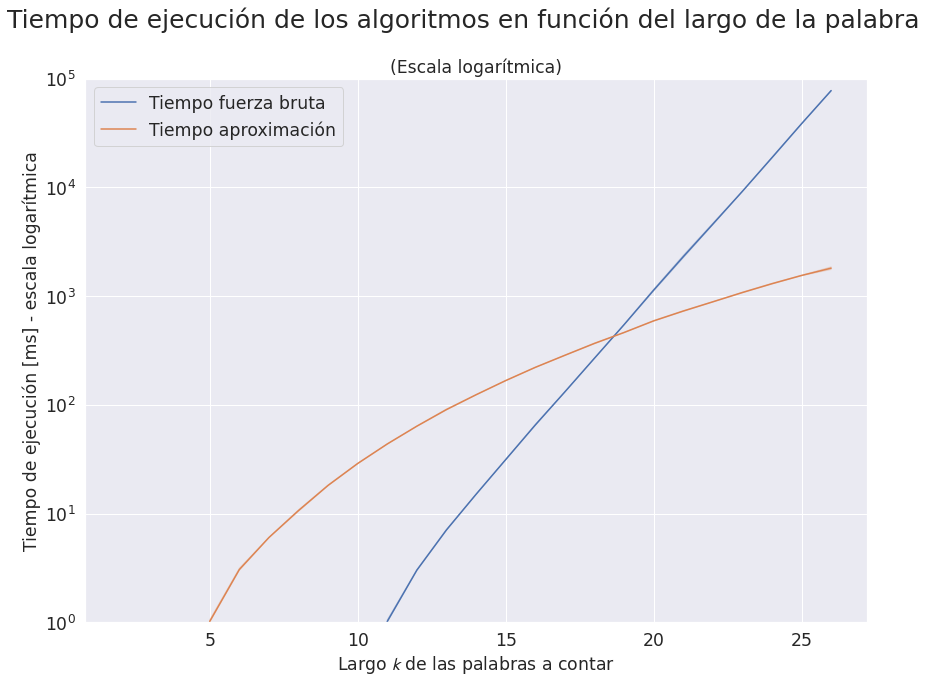

In [96]:
sns.lineplot(data=df, x="str_len", y="bruteforce_time")
sns.lineplot(data=df, x="str_len", y="estimation_time")
plt.yscale("log")
plt.ylim(1, 1e5)
plt.legend(["Tiempo fuerza bruta", "Tiempo aproximación"])
plt.ylabel("Tiempo de ejecución [ms] - escala logarítmica")
plt.xlabel("Largo $\mathcal{k}$ de las palabras a contar")
plt.suptitle("Tiempo de ejecución de los algoritmos en función del largo de la palabra", fontsize=25)
plt.title("(Escala logarítmica)");

Text(0.5, 0.98, 'Error relativo de la aproximación en función del largo de la palabra')

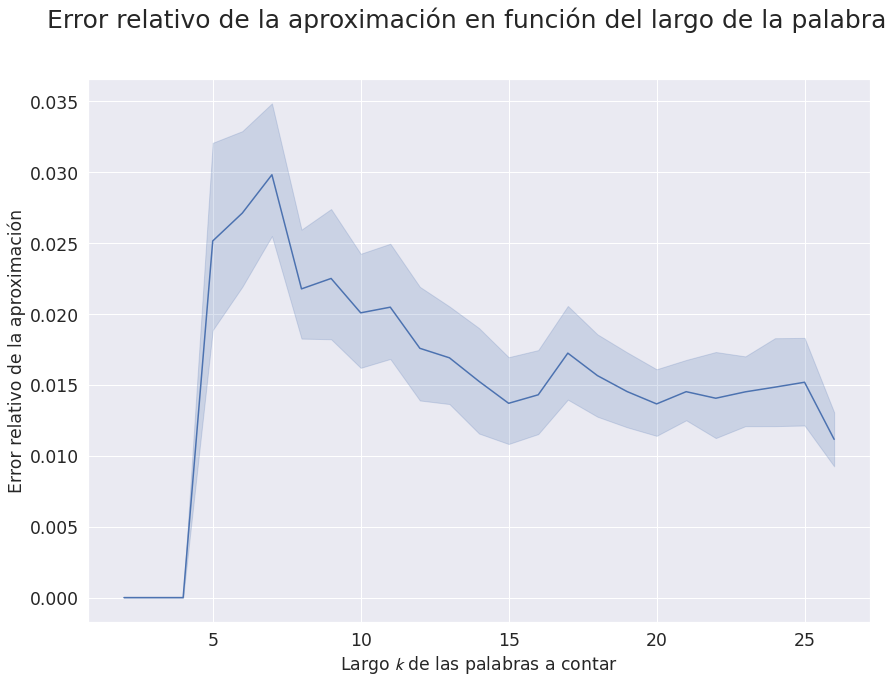

In [95]:
sns.lineplot(data=df, x="str_len", y="rel_error")
plt.ylabel("Error relativo de la aproximación")
plt.xlabel("Largo $\mathcal{k}$ de las palabras a contar")
plt.suptitle("Error relativo de la aproximación en función del largo de la palabra", fontsize=25)